# 2020 추천 여행지

In [11]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [12]:
df = pd.read_csv('../data_travel/2020 추천 여행지.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20230402,한국 관광 공사. 추천. 월 별. 여행지.(2020년 기준.). 1월 달. 덕유산 ...,<b>추천<\/b>. 월 별. <b>여행지<\/b>.(<b>2020년<\/b> 기준...,한국 관광 공사. 추천. 월 별. 여행지.(2020년 기준.).
1,20240505,"5월 전라도 여행지 추천 순창 용궐산 하늘길 코스 글, 사진, 영상: @팅이(다녀온...","5월 전라도 <b>여행지<\/b> <b>추천<\/b> 순창 용궐산 하늘길 코스 글,...",5월 전라도 여행지 추천 순창 용궐산 하늘길 코스
2,20240502,전주 이팝나무 5월 여행지 추천 전주 이팝나무 철길 팔복동 이팝나무 여행일 : 20...,전주 이팝나무 철길 <b>2020년<\/b> 5월 7일 이 사진은 <b>2020년<...,전주 이팝나무 철길 팔복동 이팝나무 5월 여행지 추천
3,20191202,다가올 2020년에 대한 기대때문인가. 2020년에 가봐야하는 추천 여행지와 오버투...,"<b>2020년<\/b>에 가봐야하는 <b>추천 여행지<\/b>와 오버투어리즘, 환...",2020년 추천 여행지 & NO GO 여행지
4,20191121,"2020년에는 어떤 여행지가 뜰까? 2019년은 여러가지 이슈들이 잇따랐지만, 베트...",<b>추천<\/b>상품 바로가기 ▶ http:\/\/bit.ly\/2O70oND 0...,[여행 트렌드] 하나투어가 제안하는 2020년 추천여행지 TOP 10!


## 1. 전처리

In [13]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [14]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['여행지', '2020년', '여행', '추천', '사진', '코스', '사람', '마을','방문', '다양', '정도', '모습',
                        '생각', '거리', '이용', '위치', '유명', '가능', '소개', '선정', '시작', '오늘', '관광', '지역', '장소',
                        '세계', '올해', '기간', '제목', '때문', '주차장', '예약', '투어', '공간', '구경', '문화', '날씨', '인기',
                        '나라', '주변', '운영', '마음', '무료', '자리', '최고', '준비', '대표', '매력', '주차', '감상', '아래',
                        '분위기', '정보', '입구', '이동', '사랑', '할인', '특별', '일정', '시설', '건물', '진행', '계획', '보이',
                        '가지', '시기', '대하', '입장료', '이름', '아침', '도착', '경우', '규모', '입장', '포스팅', '마지막', '가격',
                        '촬영', '접기펴기', '이야기', '사용', '포토', '작품', '이유', '기억', '출처', '상품', '시대', '하루', '조성',
                        '인생', '필요', '친구', '워크', '사이', '경험', '출발', '선택', '영상', '처음', '최대', '이후', '제공', '기분',
                        '중간', '지금', '계단', '요즘', '개인', '프로그램', '관광객', '곳곳', '소리', '요금', '오후', '주소', '안내',
                        '필수', '행사', '근처', '안전', '방법', '안녕하세요', '부분', '포함', '시즌', '정상', '이벤트', '지정', '작년',
                        '의미', '여행자', '공연', '배경', '전체', '자랑', '당시', '식사', '기준', '지도', '내부', '저녁', '구간',
                        '오픈', '정리', '패키지', '예술', '얼음', '일반', '네이버', '재미', '센터', '국가', '여행객', '후기', '그림',
                        '세상', '탑승',  '홈페이지', '서비스', '마련', '포인트', '참고', '먹거리', '일상', '소요', '자체', '비교',
                        '예정', '검색'
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [15]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [16]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 26s
Wall time: 4min 1s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20230402,한국 관광 공사 추천 월 별 여행지2020년 기준 1월 달 덕유산 국립 공원 전라북...,b추천b 월 별 b여행지bb2020년b 기준 1월 달 덕유산 국립 공원 전라북도 무...,한국 관광 공사 추천 월 별 여행지2020년 기준,한국 공사 달 덕유산 국립 공원 전라북도 무주군 달 도수 다원 제주 자치 서귀포 시...,달 덕유산 국립 공원 전라북도 무주군 달 도수 다원 제주 자치 서귀포 시 달 매화 ...,한국 공사 별
1,20240505,5월 전라도 여행지 추천 순창 용궐산 하늘길 코스 글 사진 영상 팅이다녀온 날 20...,5월 전라도 b여행지b b추천b 순창 용궐산 하늘길 코스 글 사진 영상 팅이다녀온 ...,5월 전라도 여행지 추천 순창 용궐산 하늘길 코스,전라도 순창 용궐 산 하늘 길 글 팅 날 신록 계절 음 풍경 나들이 만 전라도 순창...,전라도 순창 용궐 산 하늘 길 글 팅 날 신록 원 순창 용궐 산 하늘 길 개 장 래...,전라도 순창 용궐 산 하늘 길
2,20240502,전주 이팝나무 5월 여행지 추천 전주 이팝나무 철길 팔복동 이팝나무 여행일 2024...,전주 이팝나무 철길 b2020년b 5월 7일 이 사진은 b2020년b 5월 7일에 ...,전주 이팝나무 철길 팔복동 이팝나무 5월 여행지 추천,전주 이팝나무 전주 이팝나무 철길 팔복동 이팝나무 순수 주세환 남쪽 지방 집 중 전...,전주 이팝나무 철길 데 순수 풍경사진 갤러리 글 주세,전주 이팝나무 철길 팔복동 이팝나무
3,20191202,다가올 2020년에 대한 기대때문인가 2020년에 가봐야하는 추천 여행지와 오버투어...,b2020년b에 가봐야하는 b추천 여행지b와 오버투어리즘 환경 등 다양한 문제로 몸...,2020년 추천 여행지 NO GO 여행지,기대 오버투어리즘 환경 문제 몸살 번 이슈 한 주간 뉴스 백악 낙산 흥인지문 남산 ...,오버투어리즘 환경 문제 몸살 번 이슈 한 주간 뉴스,
4,20191121,2020년에는 어떤 여행지가 뜰까 2019년은 여러가지 이슈들이 잇따랐지만 베트남 ...,b추천b상품 바로가기 httpbitly2O70oND 02 이탈리아 중부 vs 남부 ...,여행 트렌드 하나투어가 제안하는 2020년 추천여행지 TOP 10,은 이슈 베트남 달랏 나트랑 태국 치앙마이 보석 발견 해 주목 궁금 가요 하나투어 ...,기 이탈리아 중부 남부 비긴 어게인 촬영지 화제 이탈리아 주목 유럽 중심,트렌드 하나투어 제안


In [17]:
# 전처리한 결과 csv로 저장 
df.to_csv('20여행지_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [18]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [19]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [20]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
1899,국내,1788
21797,풍경,1651
757,겨울,1591
128,가을,1353
19403,축제,1326
7401,바다,1261
1399,공원,1110
4472,도시,1028
19157,체험,991
13761,여름,951


In [21]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['국내',
 '풍경',
 '겨울',
 '가을',
 '축제',
 '바다',
 '공원',
 '도시',
 '체험',
 '여름',
 '제주',
 '자연',
 '호텔',
 '명소',
 '가족',
 '카페',
 '부산',
 '정원',
 '벚꽃',
 '단풍',
 '서울',
 '해변',
 '전망대',
 '해외',
 '다리',
 '코로나',
 '강원도',
 '계곡',
 '한국',
 '하늘']

### [preprocessed_description]

In [22]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [23]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
342,국내,247
145,겨울,137
3198,코로나,100
22,가을,100
3624,해외,99
2159,여름,85
3115,축제,80
2799,제주,70
28,가족,64
1108,명소,61


### [preprocessed_title]

In [24]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [25]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
158,국내,233
59,겨울,107
1716,해외,85
10,가을,74
1033,여름,48
1463,축제,47
14,가족,47
513,명소,44
1338,제주,40
673,부산,34


## 3. 계절별로 데이터프레임 생성

In [26]:
# 특정 키워드 포함 행 필터링 함수
def filter_inclusive(df, keyword):
    return df[df['preprocessed_body'].str.contains(keyword, na=False)]

# 특정 키워드 포함하지 않는 행 제거 함수
def filter_exclusive(df, exclude_keywords):
    return df[~df['preprocessed_body'].str.contains('|'.join(exclude_keywords), na=False)]

# 봄 데이터프레임 생성
spring_df = filter_inclusive(df, '봄')
spring_df = filter_exclusive(spring_df, ['여름', '가을', '겨울'])

# 여름 데이터프레임 생성
summer_df = filter_inclusive(df, '여름')
summer_df = filter_exclusive(summer_df, ['봄', '가을', '겨울'])

# 가을 데이터프레임 생성
autumn_df = filter_inclusive(df, '가을')
autumn_df = filter_exclusive(autumn_df, ['봄', '여름', '겨울'])

# 겨울 데이터프레임 생성
winter_df = filter_inclusive(df, '겨울')
winter_df = filter_exclusive(winter_df, ['봄', '여름', '가을'])

# preprocessed_body, postdate 열만 추출
spring_body = spring_df[['preprocessed_body', 'postdate']]
summer_body = summer_df[['preprocessed_body', 'postdate']]
autumn_body = autumn_df[['preprocessed_body', 'postdate']]
winter_body = winter_df[['preprocessed_body', 'postdate']]

In [27]:
# # 사계절 데이터프레임 csv로 저장
# spring_body.to_csv('20여행지_전처리_봄.csv', index=False, encoding='utf-8-sig')
# summer_body.to_csv('20여행지_전처리_여름.csv', index=False, encoding='utf-8-sig')
# autumn_body.to_csv('20여행지_전처리_가을.csv', index=False, encoding='utf-8-sig')
# winter_body.to_csv('20여행지_전처리_겨울.csv', index=False, encoding='utf-8-sig')

### [spring]

In [28]:
# 봄 데이터프레임에 대해 단어 빈도 계산
spring_word_counts = explode_and_count(spring_body, 'preprocessed_body')

# 한 글자 단어 제외
spring_word_counts = spring_word_counts[spring_word_counts['word'].str.len() > 1]
spring_word_counts.head(30)

,word,count
2,벚꽃,183
17,국내,104
18,축제,100
22,공원,88
27,카페,75
28,바다,74
30,체험,69
31,가족,65
32,유채,65
34,신안,64


### [summer]

In [29]:
# 여름 데이터프레임에 대해 단어 빈도 계산
summer_word_counts = explode_and_count(summer_body, 'preprocessed_body')

# 한 글자 단어 제외
summer_word_counts = summer_word_counts[summer_word_counts['word'].str.len() > 1]
summer_word_counts.head(30)

,word,count
4,여름,357
5,해수욕장,313
10,국내,250
12,바다,236
16,계곡,215
17,해변,198
18,축제,192
19,풍경,191
29,부산,132
30,자연,126


### [autumn]

In [30]:
# 가을 데이터프레임에 대해 단어 빈도 계산
autumn_word_counts = explode_and_count(autumn_body, 'preprocessed_body')

# 한 글자 단어 제외
autumn_word_counts = autumn_word_counts[autumn_word_counts['word'].str.len() > 1]
autumn_word_counts.head(30)

,word,count
2,가을,386
6,단풍,211
10,축제,162
13,공원,140
15,국내,135
19,명소,124
20,풍경,115
23,서울,99
24,수목원,99
25,코스모스,98


### [winter]

In [31]:
# 겨울 데이터프레임에 대해 단어 빈도 계산
winter_word_counts = explode_and_count(winter_body, 'preprocessed_body')

# 한 글자 단어 제외
winter_word_counts = winter_word_counts[winter_word_counts['word'].str.len() > 1]
winter_word_counts.head(30)

,word,count
2,겨울,457
9,국내,209
16,연휴,140
17,도시,138
20,해외,118
21,가족,117
22,풍경,113
23,호텔,112
25,제주,105
28,유럽,102


## 4. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [32]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [33]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'국내': 1788,
 '풍경': 1651,
 '겨울': 1591,
 '가을': 1353,
 '축제': 1326,
 '바다': 1261,
 '공원': 1110,
 '도시': 1028,
 '체험': 991,
 '여름': 951,
 '제주': 907,
 '자연': 878,
 '호텔': 860,
 '명소': 852,
 '가족': 812,
 '카페': 760,
 '부산': 736,
 '정원': 699,
 '벚꽃': 686,
 '단풍': 661,
 '서울': 661,
 '해변': 639,
 '전망대': 632,
 '해외': 620,
 '다리': 614,
 '코로나': 588,
 '강원도': 582,
 '계곡': 578,
 '한국': 577,
 '하늘': 566,
 '느낌': 566,
 '관광지': 561,
 '힐링': 552,
 '리조트': 548,
 '역사': 527,
 '수목원': 522,
 '나무': 513,
 '유럽': 507,
 '해수욕장': 502,
 '박물관': 473,
 '재생': 470,
 '전시': 461,
 '관람': 443,
 '국립': 425,
 '수국': 417,
 '제주도': 396,
 '산책': 396,
 '베트남': 390,
 '볼거리': 387,
 '일본': 385,
 '주말': 381,
 '여수': 381,
 '케이블카': 379,
 '바람': 373,
 '여유': 368,
 '연휴': 367,
 '추억': 366,
 '자유': 359,
 '숙소': 356,
 '전국': 356,
 '호수': 356,
 '음식': 356,
 '야경': 348,
 '스카이': 339,
 '폭포': 332,
 '경기도': 326,
 '확인': 320,
 '바위': 317,
 '일출': 307,
 '버스': 307,
 '전통': 304,
 '항공': 304,
 '맛집': 303,
 '영화': 300,
 '펜션': 296,
 '경남': 292,
 '근교': 282,
 '계절': 280,
 '라면': 277,
 '객실': 277,
 '온실': 276,
 '강릉

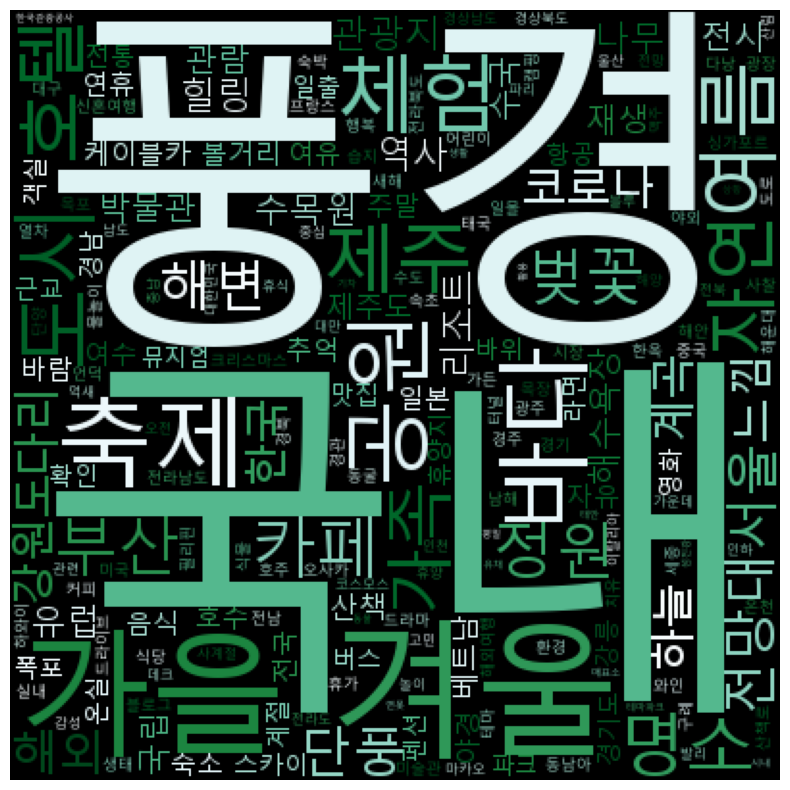

In [41]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBu': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [42]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'국내': 247,
 '겨울': 137,
 '코로나': 100,
 '가을': 100,
 '해외': 99,
 '여름': 85,
 '축제': 80,
 '제주': 70,
 '가족': 64,
 '명소': 61,
 '부산': 53,
 '강원도': 48,
 '도시': 48,
 '신혼': 46,
 '단풍': 44,
 '관광지': 39,
 '공원': 37,
 '서울': 37,
 '바다': 36,
 '한국': 36,
 '제주도': 34,
 '연휴': 33,
 '벚꽃': 33,
 '전국': 32,
 '다리': 31,
 '전망대': 31,
 '새해': 31,
 '수목원': 31,
 '국립': 31,
 '근교': 30,
 '풍경': 30,
 '여수': 30,
 '경남': 30,
 '개장': 29,
 '호텔': 28,
 '자연': 27,
 '체험': 27,
 '정원': 26,
 '박물관': 26,
 '맛집': 26,
 '동남아': 26,
 '유럽': 25,
 '힐링': 25,
 '일본': 23,
 '해수욕장': 23,
 '거제': 23,
 '전남': 22,
 '충남': 22,
 '발리': 22,
 '개관': 22,
 '경주': 22,
 '구례': 21,
 '한국관광공사': 20,
 '역사': 20,
 '맞이': 20,
 '주말': 20,
 '해외여행': 19,
 '전라도': 19,
 '계곡': 19,
 '드라이브': 19,
 '대구': 19,
 '여행사': 18,
 '인하': 18,
 '관람': 18,
 '허니문': 18,
 '여름휴가': 17,
 '행복': 17,
 '사업': 17,
 '미국': 16,
 '리조트': 16,
 '파크': 16,
 '펜션': 16,
 '주목': 16,
 '항공': 16,
 '수국': 16,
 '광주': 16,
 '말티재': 15,
 '테마': 15,
 '목포': 15,
 '공사': 15,
 '단양': 15,
 '남해': 15,
 '신혼여행': 15,
 '볼거리': 15,
 '연말': 14,
 '베트남': 14,
 '전시': 14,
 '내년': 14,

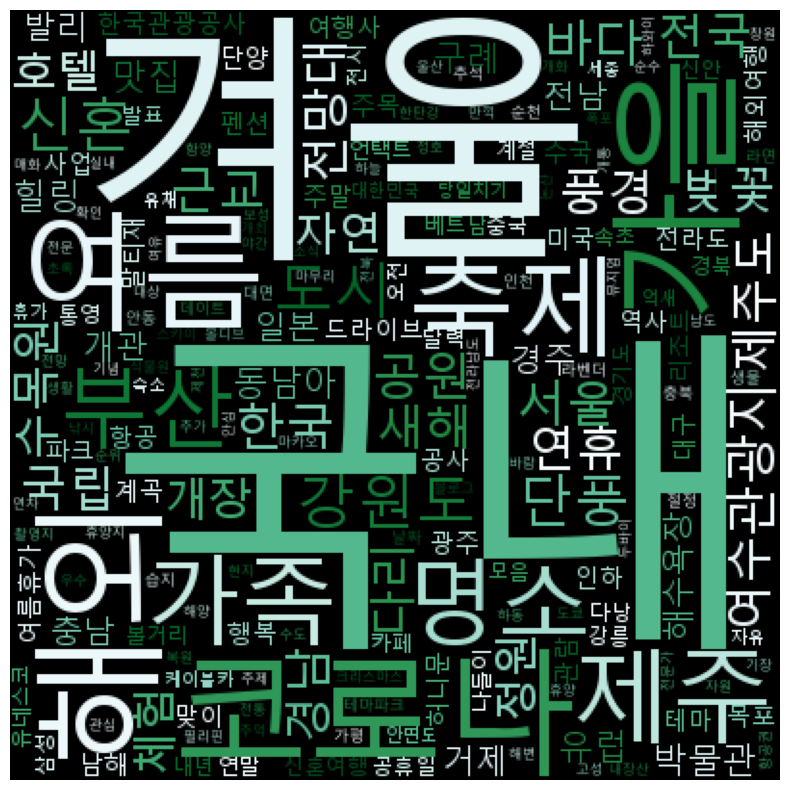

In [43]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [44]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'국내': 233,
 '겨울': 107,
 '해외': 85,
 '가을': 74,
 '여름': 48,
 '축제': 47,
 '가족': 47,
 '명소': 44,
 '제주': 40,
 '부산': 34,
 '강원도': 31,
 '대구': 27,
 '해외여행': 26,
 '전라도': 26,
 '공원': 25,
 '신혼여행': 24,
 '단풍': 24,
 '근교': 23,
 '전남': 23,
 '연휴': 23,
 '서울': 23,
 '동남아': 21,
 '힐링': 21,
 '국립': 20,
 '수목원': 20,
 '경남': 18,
 '벚꽃': 18,
 '유럽': 18,
 '여수': 18,
 '새해': 18,
 '일본': 17,
 '코로나': 17,
 '전국': 17,
 '해수욕장': 17,
 '호텔': 16,
 '바다': 16,
 '다리': 16,
 '연말': 16,
 '풍경': 15,
 '맛집': 15,
 '주목': 15,
 '거제': 15,
 '박물관': 14,
 '단양': 14,
 '제주도': 14,
 '베스트': 13,
 '실내': 13,
 '계곡': 13,
 '자유': 13,
 '볼거리': 13,
 '경북': 12,
 '정원': 12,
 '당일치기': 12,
 '언택트': 12,
 '관광지': 12,
 '세종': 12,
 '강릉': 12,
 '베트남': 11,
 '전북': 11,
 '충북': 11,
 '충남': 11,
 '필리핀': 11,
 '데이트': 11,
 '경주': 11,
 '뮤지엄': 11,
 '신혼': 11,
 '도시': 11,
 '해남': 11,
 '리조트': 11,
 '경기도': 11,
 '광주': 10,
 '여행사': 10,
 '목포': 10,
 '논산': 10,
 '항공권': 10,
 '고성': 10,
 '휴가': 10,
 '카페': 9,
 '야경': 9,
 '하동': 9,
 '제천': 9,
 '리스트': 9,
 '체험': 9,
 '구례': 9,
 '케이블카': 9,
 '추억': 9,
 '전망대': 9,
 '수국': 9,
 '나들이': 9,

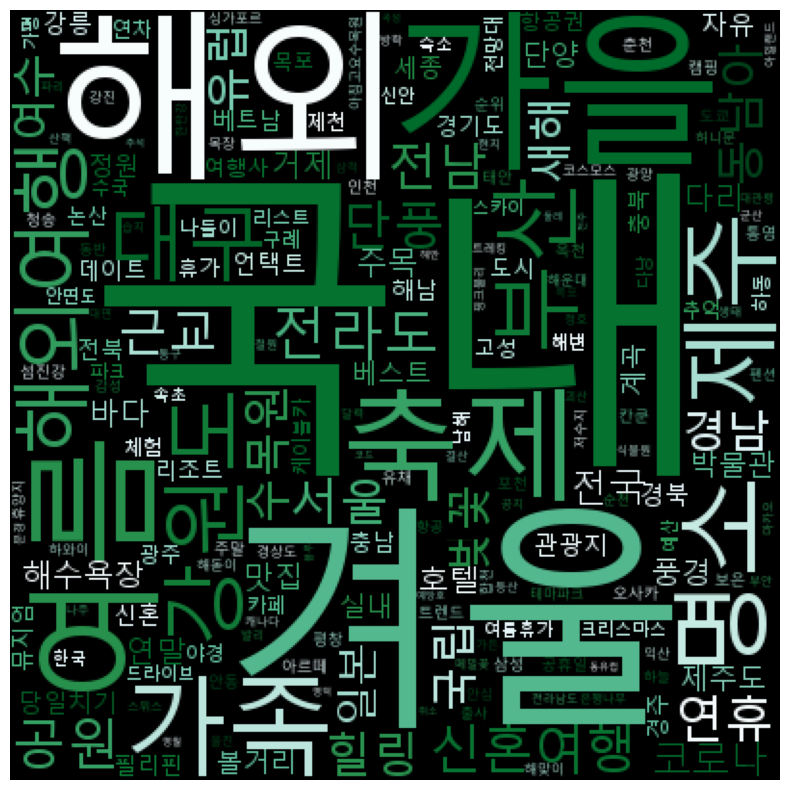

In [45]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Spring WordCloud]

In [46]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = spring_word_counts.set_index('word').to_dict()['count']
dic_word

{'벚꽃': 183,
 '국내': 104,
 '축제': 100,
 '공원': 88,
 '카페': 75,
 '바다': 74,
 '체험': 69,
 '가족': 65,
 '유채': 65,
 '신안': 64,
 '나무': 53,
 '풍경': 52,
 '다리': 52,
 '도시': 48,
 '무주': 47,
 '강릉': 47,
 '힐링': 45,
 '명소': 44,
 '부석사': 44,
 '펜션': 44,
 '한국': 43,
 '제주도': 43,
 '관광지': 43,
 '전망대': 43,
 '렌트카': 43,
 '자연': 42,
 '리조트': 42,
 '강원도': 42,
 '제주': 42,
 '객실': 41,
 '최저': 41,
 '김유정': 39,
 '남해': 38,
 '감성': 38,
 '광주': 38,
 '산수유': 37,
 '치유': 36,
 '추억': 36,
 '신혼여행': 35,
 '바람': 35,
 '휴양지': 35,
 '모노레일': 34,
 '국립': 34,
 '시장': 34,
 '울진': 33,
 '볼거리': 33,
 '주말': 33,
 '하늘': 33,
 '해변': 33,
 '도로': 32,
 '퍼플교': 32,
 '기념관': 32,
 '부산': 32,
 '꽃잔디': 31,
 '호남': 31,
 '뮤지엄': 31,
 '튤립': 31,
 '터키': 31,
 '아일랜드': 31,
 '정원': 30,
 '호국': 30,
 '사찰': 30,
 '호텔': 29,
 '숙소': 29,
 '서울': 29,
 '여유': 28,
 '산책': 28,
 '자전거': 28,
 '전남': 28,
 '재생': 27,
 '전라남도': 27,
 '연휴': 27,
 '역사': 27,
 '근교': 27,
 '느낌': 27,
 '봄꽃': 26,
 '교동': 26,
 '반월': 25,
 '보라색': 25,
 '문경': 25,
 '바위': 24,
 '습지': 24,
 '대명사': 24,
 '빌라': 23,
 '대관령': 23,
 '관람': 23,
 '해외': 23,
 '바르셀로나': 23,

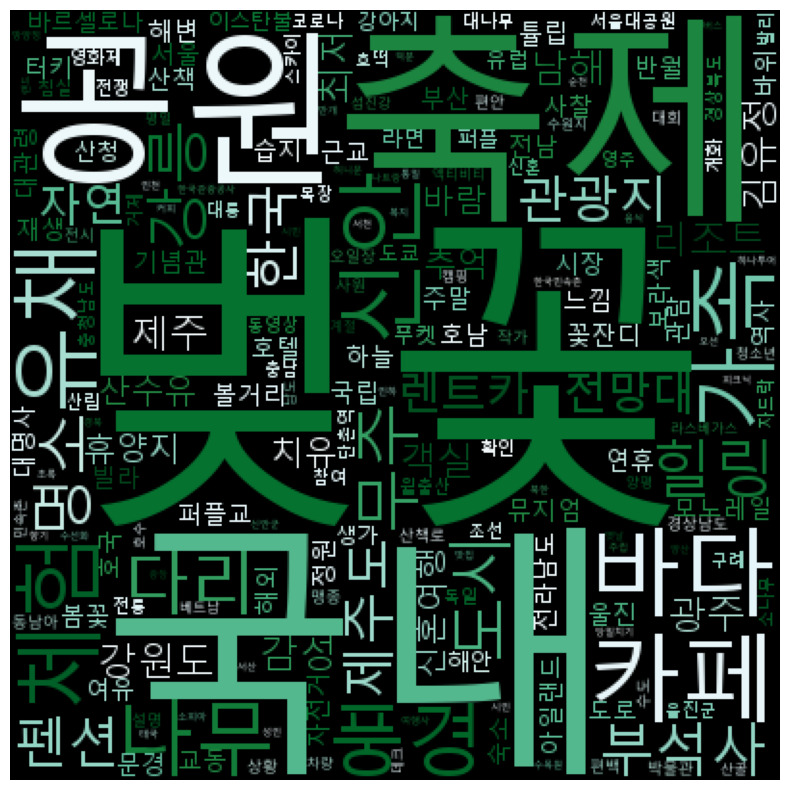

In [47]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Summer WordCloud]

In [48]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = summer_word_counts.set_index('word').to_dict()['count']
dic_word

{'여름': 357,
 '해수욕장': 313,
 '국내': 250,
 '바다': 236,
 '계곡': 215,
 '해변': 198,
 '축제': 192,
 '풍경': 191,
 '부산': 132,
 '자연': 126,
 '강원도': 122,
 '도시': 118,
 '수국': 111,
 '공원': 108,
 '관광지': 102,
 '체험': 98,
 '전망대': 95,
 '박물관': 93,
 '서울': 88,
 '명소': 81,
 '한국': 80,
 '느낌': 78,
 '휴가': 76,
 '전국': 75,
 '정원': 74,
 '단양': 73,
 '주간': 72,
 '물놀이': 72,
 '제주': 72,
 '힐링': 69,
 '가족': 69,
 '코로나': 68,
 '다리': 67,
 '스카이': 64,
 '와인': 64,
 '경기도': 63,
 '카페': 63,
 '호텔': 62,
 '경남': 62,
 '폭포': 61,
 '가평': 60,
 '놀이터': 60,
 '역사': 60,
 '남해': 59,
 '원주': 58,
 '경상남도': 57,
 '전라남도': 57,
 '여름휴가': 56,
 '해남': 55,
 '하늘': 55,
 '베트남': 55,
 '나무': 54,
 '바위': 53,
 '인천': 53,
 '산책': 52,
 '이탈리아': 52,
 '보문사': 51,
 '반려동물': 51,
 '오륙도': 51,
 '동굴': 51,
 '전시': 50,
 '추억': 49,
 '철원': 48,
 '소원': 48,
 '편백': 47,
 '격포': 47,
 '시원': 47,
 '숙소': 47,
 '공휴일': 47,
 '경기': 47,
 '개장': 46,
 '라벤더': 46,
 '고성': 46,
 '보부상': 46,
 '한강': 45,
 '볼거리': 45,
 '수목원': 44,
 '숙박': 44,
 '해외': 44,
 '대한민국': 43,
 '대나무': 43,
 '국립': 41,
 '드라마': 41,
 '캠핑': 41,
 '드라이브': 40,
 '음식': 39,
 '케이

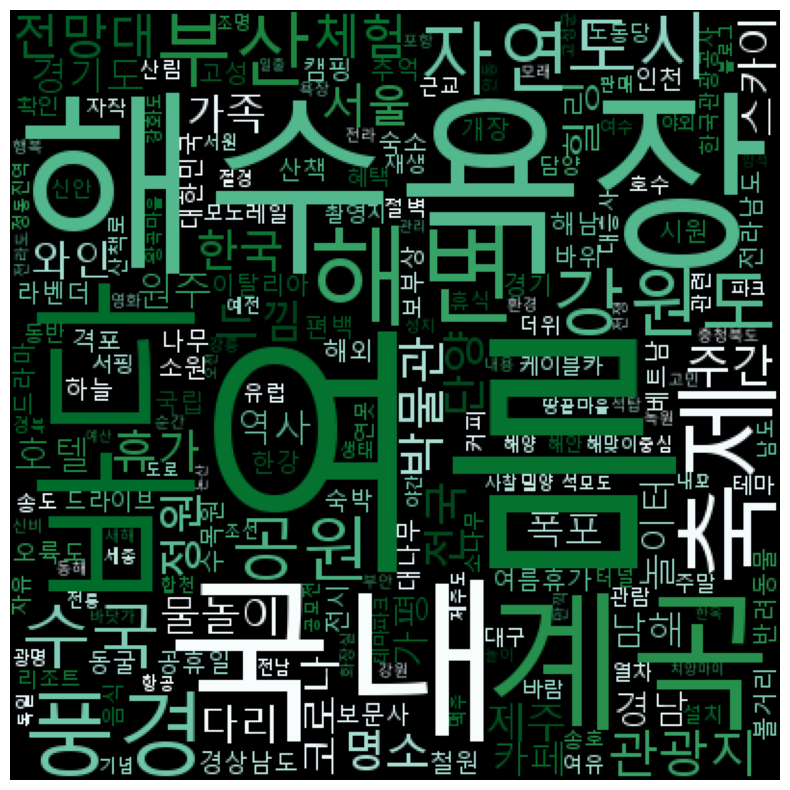

In [49]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Autumn WordCloud]

In [50]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = autumn_word_counts.set_index('word').to_dict()['count']
dic_word

{'가을': 386,
 '단풍': 211,
 '축제': 162,
 '공원': 140,
 '국내': 135,
 '명소': 124,
 '풍경': 115,
 '서울': 99,
 '수목원': 99,
 '코스모스': 98,
 '경남': 88,
 '가족': 76,
 '은행나무': 71,
 '도시': 66,
 '정원': 65,
 '힐링': 61,
 '케이블카': 60,
 '국립': 60,
 '대구': 59,
 '체험': 56,
 '바다': 55,
 '내장산': 55,
 '경주': 55,
 '코로나': 55,
 '경기': 53,
 '목포': 53,
 '창원': 53,
 '전국': 53,
 '해외': 52,
 '중국': 52,
 '경북': 52,
 '속초': 50,
 '온실': 50,
 '화담': 49,
 '세종': 49,
 '핑크뮬리': 49,
 '저수지': 49,
 '역사': 48,
 '자연': 47,
 '재생': 47,
 '억새': 45,
 '안면도': 44,
 '강원도': 43,
 '테마': 43,
 '산책': 43,
 '괴산': 43,
 '메밀꽃': 42,
 '박물관': 42,
 '추석': 42,
 '연못': 41,
 '관람': 41,
 '식물': 41,
 '나무': 40,
 '구미': 39,
 '하동': 38,
 '내장사': 38,
 '자유': 38,
 '느낌': 38,
 '볼거리': 37,
 '관광지': 36,
 '생태': 36,
 '전시': 36,
 '울산': 35,
 '계곡': 35,
 '강원': 34,
 '한국': 34,
 '하늘': 34,
 '제주도': 33,
 '카페': 33,
 '생물': 33,
 '경상북도': 32,
 '캠핑': 32,
 '식당': 31,
 '칼국수': 30,
 '연휴': 30,
 '유수지': 30,
 '바람': 29,
 '대명': 29,
 '매표소': 29,
 '맛집': 28,
 '은행': 28,
 '산청': 28,
 '경기도': 27,
 '전라도': 27,
 '주말': 27,
 '제주': 27,
 '작가': 27,
 '안면': 26

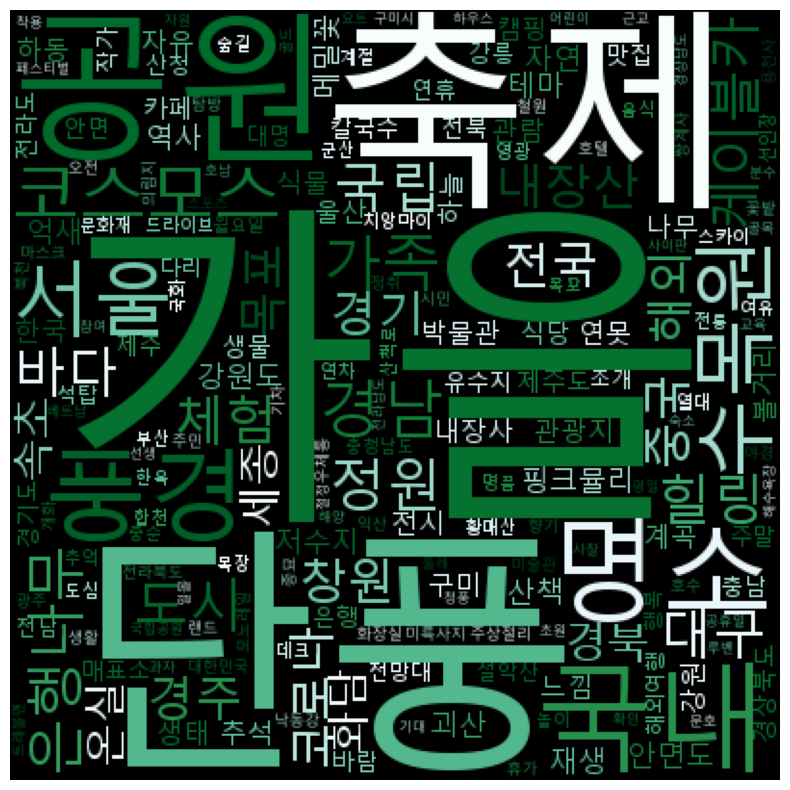

In [51]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Winter WordCloud]

In [52]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = winter_word_counts.set_index('word').to_dict()['count']
dic_word

{'겨울': 457,
 '국내': 209,
 '연휴': 140,
 '도시': 138,
 '해외': 118,
 '가족': 117,
 '풍경': 113,
 '호텔': 112,
 '제주': 105,
 '유럽': 102,
 '명소': 98,
 '체험': 95,
 '축제': 92,
 '바다': 91,
 '특가': 81,
 '자연': 80,
 '베트남': 78,
 '하늘': 75,
 '리조트': 74,
 '항공': 63,
 '와인': 61,
 '부산': 61,
 '일본': 59,
 '다낭': 58,
 '힐링': 56,
 '단양': 56,
 '크리스마스': 54,
 '설날': 54,
 '공원': 54,
 '카페': 53,
 '한국': 53,
 '박물관': 53,
 '국립': 52,
 '서울': 51,
 '군밤': 51,
 '역사': 50,
 '세부': 49,
 '관람': 48,
 '항공권': 48,
 '야경': 47,
 '일출': 47,
 '파크': 46,
 '수목원': 45,
 '공주': 45,
 '정원': 45,
 '다리': 44,
 '여유': 42,
 '목장': 42,
 '세종': 41,
 '새해': 41,
 '음식': 41,
 '전시': 41,
 '소백산': 41,
 '일몰': 40,
 '라면': 40,
 '관광지': 40,
 '습지': 39,
 '두바이': 39,
 '휴양지': 39,
 '마카오': 38,
 '경기도': 38,
 '나트랑': 38,
 '추억': 38,
 '필리핀': 38,
 '느낌': 37,
 '펜션': 37,
 '동남아': 36,
 '오사카': 35,
 '제주도': 35,
 '전망대': 35,
 '마켓': 35,
 '동유럽': 35,
 '한옥': 35,
 '태국': 34,
 '볼거리': 34,
 '코드': 34,
 '실내': 34,
 '익산': 33,
 '대구': 33,
 '해외여행': 32,
 '보호': 32,
 '방학': 32,
 '재생': 32,
 '맛집': 31,
 '인근': 31,
 '터널': 31,
 '프로방스': 31,
 '프로모션'

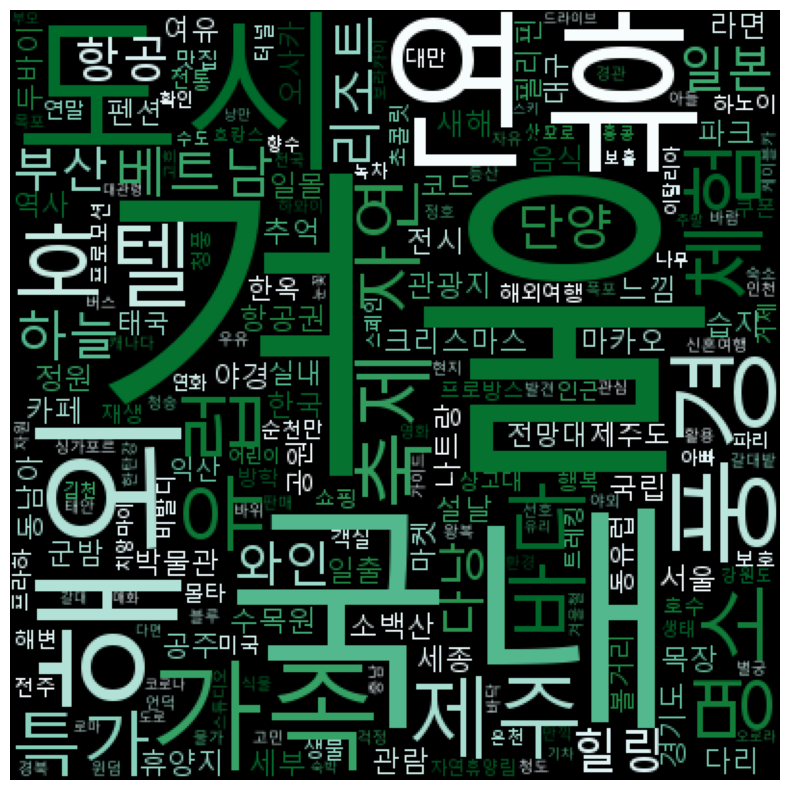

In [53]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기